In [22]:
import numpy as np
import matplotlib.pyplot as plt
import gravhydro as gh
import astropy.units as u

In [23]:
# === CENTRAL PERTURBATION TEST PARAMETERS ===
nx, ny = 30, 30  # grid dimensions
total_N = nx * ny
amplitude = 0.05  # perturbation strength
cs = 0.1  # sound speed
perturbation_width = 0.1  # Gaussian width of the perturbation

Total particles: 900
Particle spacing: dx=0.0690, dy=0.0690


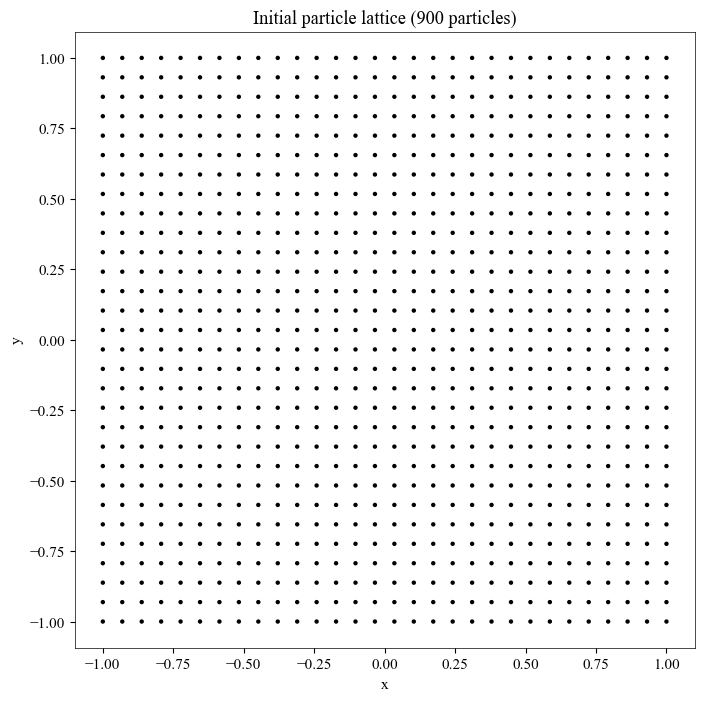

In [24]:
# === 2D SQUARE LATTICE SETUP ===
# Uniform grid of particles - this is a stable equilibrium configuration

x_min, x_max = -1, 1
y_min, y_max = -1, 1

xs = np.linspace(x_min, x_max, nx)
ys = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(xs, ys)

pos = np.vstack([xx.ravel(), yy.ravel()]).T
actual_N = len(pos)

# Particle spacing
dx = xs[1] - xs[0]
dy = ys[1] - ys[0]
print(f"Total particles: {actual_N}")
print(f"Particle spacing: dx={dx:.4f}, dy={dy:.4f}")

# quick visual check
plt.figure(figsize=(8, 8))
plt.scatter(pos[:, 0], pos[:, 1], s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Initial particle lattice ({actual_N} particles)')
plt.axis('equal')
plt.show()

In [25]:
from scipy.spatial.distance import pdist

def min_interparticle_distance(positions):
    """
    Calculate the minimum distance between any two particles in the position array.
    
    Parameters:
    positions : numpy.ndarray
        Array of shape (N, 2) containing particle positions
        
    Returns:
    float
        Minimum interparticle distance
    """
    
    # Calculate all pairwise distances
    distances = pdist(positions)
    
    # Return the minimum distance
    return distances.min()

# Calculate minimum interparticle distance for the current grid
min_dist = min_interparticle_distance(pos)
print(f"Minimum interparticle distance: {min_dist:.6f}")

Minimum interparticle distance: 0.068966


(array([30948., 55214., 71152., 74014., 68466., 55956., 33858., 11876.,
         2786.,   280.]),
 array([0.06896552, 0.34491168, 0.62085784, 0.896804  , 1.17275016,
        1.44869632, 1.72464248, 2.00058864, 2.2765348 , 2.55248096,
        2.82842712]),
 <BarContainer object of 10 artists>)

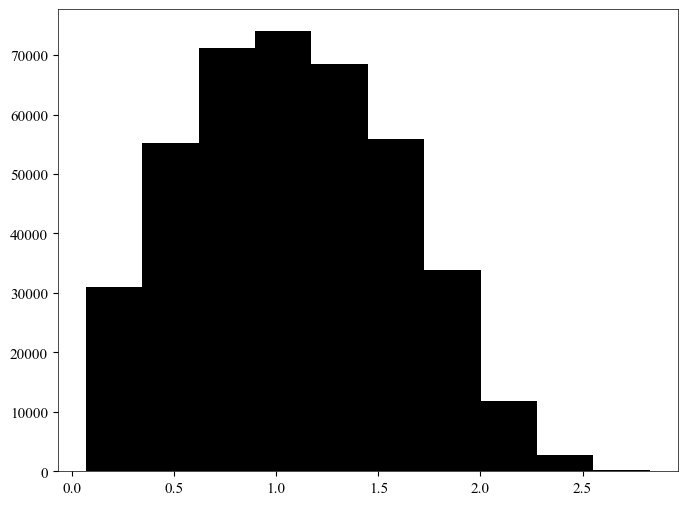

In [26]:
plt.hist(pdist(pos))

In [27]:
# Smoothing length - should be ~2-3x particle spacing for SPH
h = 2.5 * dx
print(f"Smoothing length h: {h:.6f}")
print(f"h/dx ratio: {h/dx:.2f} (typically 2-3 for good SPH behavior)")

Smoothing length h: 0.172414
h/dx ratio: 2.50 (typically 2-3 for good SPH behavior)


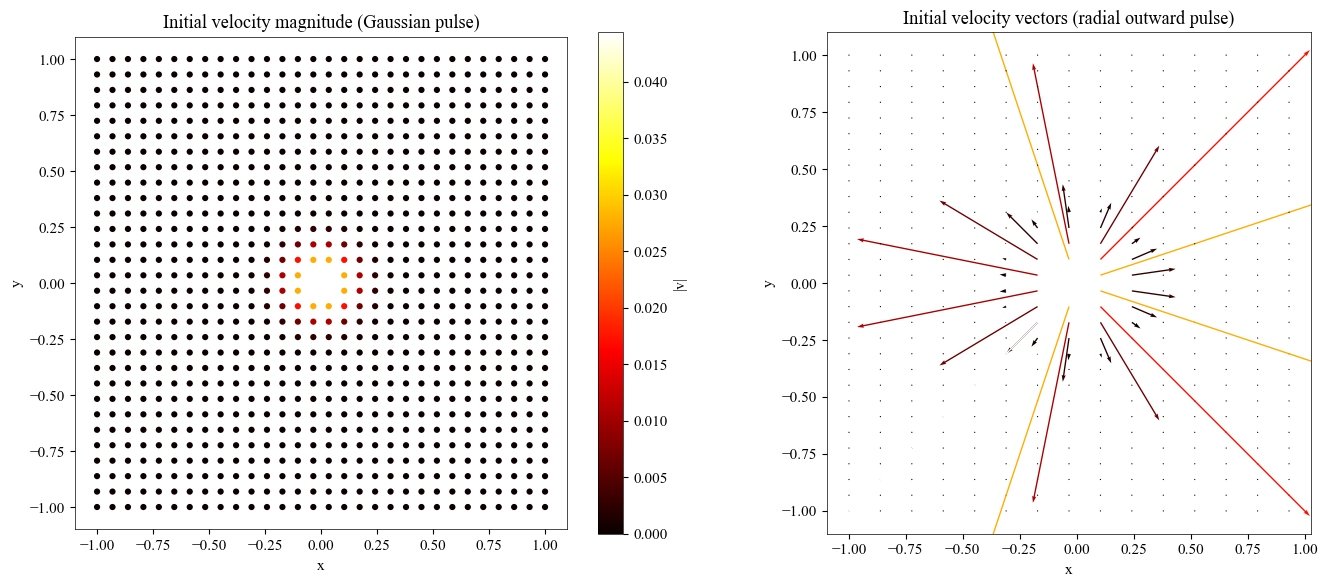

Max velocity: 0.0444
Sound speed: 0.1
Max Mach number: 0.4439


In [28]:
# === CENTRAL GAUSSIAN PERTURBATION ===
# Radial outward velocity kick centered at origin
# v = A * exp(-r²/σ²) * r_hat  (outward pulse)

# Distance from center
r = np.sqrt(pos[:, 0]**2 + pos[:, 1]**2)
r_safe = np.maximum(r, 1e-10)  # avoid division by zero

# Gaussian envelope
gaussian = amplitude * np.exp(-r**2 / (2 * perturbation_width**2))

# Radial unit vectors (outward from center)
r_hat_x = pos[:, 0] / r_safe
r_hat_y = pos[:, 1] / r_safe

# Velocity = Gaussian * radial direction (outward pulse)
vel = np.zeros_like(pos)
vel[:, 0] = gaussian * r_hat_x
vel[:, 1] = gaussian * r_hat_y

# Visualize initial velocity field
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Velocity magnitude
sc = axes[0].scatter(pos[:, 0], pos[:, 1], c=np.sqrt(vel[:, 0]**2 + vel[:, 1]**2), 
                     cmap='hot', s=20)
plt.colorbar(sc, ax=axes[0], label='|v|')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Initial velocity magnitude (Gaussian pulse)')
axes[0].set_aspect('equal')

# Velocity vectors (subsample for clarity)
skip = 2
axes[1].quiver(pos[::skip, 0], pos[::skip, 1], vel[::skip, 0], vel[::skip, 1], 
               np.sqrt(vel[::skip, 0]**2 + vel[::skip, 1]**2), cmap='hot')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Initial velocity vectors (radial outward pulse)')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"Max velocity: {np.sqrt(vel[:, 0]**2 + vel[:, 1]**2).max():.4f}")
print(f"Sound speed: {cs}")
print(f"Max Mach number: {np.sqrt(vel[:, 0]**2 + vel[:, 1]**2).max()/cs:.4f}")

In [29]:
# Uniform mass distribution
masses = np.ones(actual_N) * 1.0 / actual_N
print(f"Total mass: {masses.sum():.4f}")

Total mass: 1.0000


In [30]:
# === TIME SETUP ===
# Time for wave to cross the domain: t_cross ~ L / cs
# where L is the domain size

L = x_max - x_min  # domain size
t_cross = L / cs   # crossing time

n_crossings = 1.5  # run for 1.5 crossing times
dt = 0.005 * t_cross  # ~200 steps per crossing

t_end = n_crossings * t_cross
ts = gh.convert_to_physical(np.arange(0, t_end, dt), 'time', True, None, None, None)

print(f"Domain size: {L}")
print(f"Wave crossing time: {t_cross:.2f}")
print(f"Simulation time: {t_end:.2f} ({n_crossings} crossings)")
print(f"Number of timesteps: {len(ts)}")
print(f"dt = {dt:.4f}")

Domain size: 2
Wave crossing time: 20.00
Simulation time: 30.00 (1.5 crossings)
Number of timesteps: 300
dt = 0.1000


In [31]:
# === RUN SIMULATION ===
sim = gh.Simulation()
sim.run(pos, vel, masses, ts, 
        gravityMethod='directSummation', 
        use_numba=True, 
        gravityOnly=False, 
        hydroOnly=True,  # Pure hydro - no gravity
        h=h, 
        cs=cs,  # Sound speed
        softening=1 * u.pc)

  0%|          | 0/299 [00:00<?, ?it/s]

100%|██████████| 299/299 [00:01<00:00, 227.77it/s]



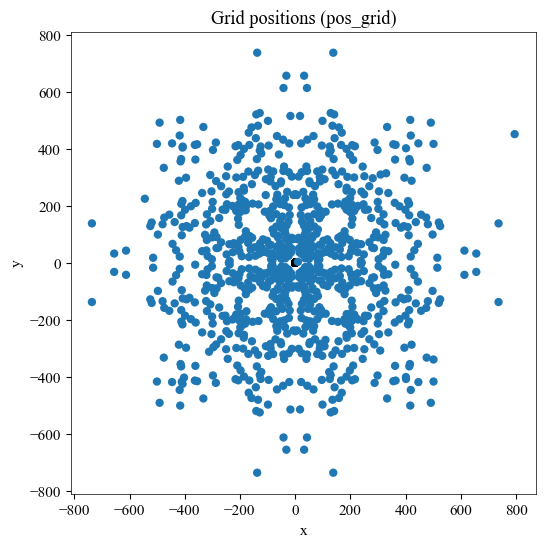

In [32]:
plt.figure(figsize=(6,6))
#plt.scatter(pos[:,0], pos[:,1], s=10)
plt.scatter(sim.positions[0, :, 0], sim.positions[0, :, 1])
plt.scatter(sim.positions[-1, :, 0], sim.positions[-1, :, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Grid positions (pos_grid)')
plt.show()

In [33]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(7, 7))

def update(frame):
    ax.clear()
    #ax.scatter(sim.positions[0, :, 0], sim.positions[0, :, 1], alpha=0.5, label='Initial')
    ax.scatter(sim.positions[frame*10, :, 0], sim.positions[frame*10, :, 1], alpha=0.75, label=f'Frame {frame*10}')
    # ax.set_xlim(-0.01, 0.01)
    # ax.set_ylim(-0.01, 0.01)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Particle Positions - Timestep {frame*10}/{len(sim.positions)-1}')

anim = FuncAnimation(fig, update, frames=len(sim.positions)//10, interval=100, repeat=True)
plt.close()
HTML(anim.to_jshtml())

In [34]:
# === ENERGY CONSERVATION CHECK ===
# Calculate kinetic energy at each timestep
# For isothermal gas, we track kinetic energy (thermal energy is implicitly handled by cs)

def kinetic_energy(velocities, masses):
    """Calculate total kinetic energy: KE = 0.5 * sum(m * v^2)"""
    v_squared = np.sum(velocities**2, axis=1)  # |v|^2 for each particle
    return 0.5 * np.sum(masses * v_squared)

# Calculate KE at each timestep
KE = np.array([kinetic_energy(sim.velocities[i], masses) for i in range(len(sim.velocities))])

# Plot energy evolution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute KE
axes[0].plot(np.arange(len(KE)) * dt, KE)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Kinetic Energy')
axes[0].set_title('Kinetic Energy vs Time')
axes[0].axhline(KE[0], color='r', linestyle='--', alpha=0.5, label='Initial KE')
axes[0].legend()

# Relative change
relative_change = (KE - KE[0]) / KE[0] * 100
axes[1].plot(np.arange(len(KE)) * dt, relative_change)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Energy Change (%)')
axes[1].set_title('Relative Energy Change')
axes[1].axhline(0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Initial KE: {KE[0]:.6e}")
print(f"Final KE: {KE[-1]:.6e}")
print(f"Energy change: {relative_change[-1]:.4f}%")

TypeError: only dimensionless scalar quantities can be converted to Python scalars

UnitConversionError: Can only apply 'maximum' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

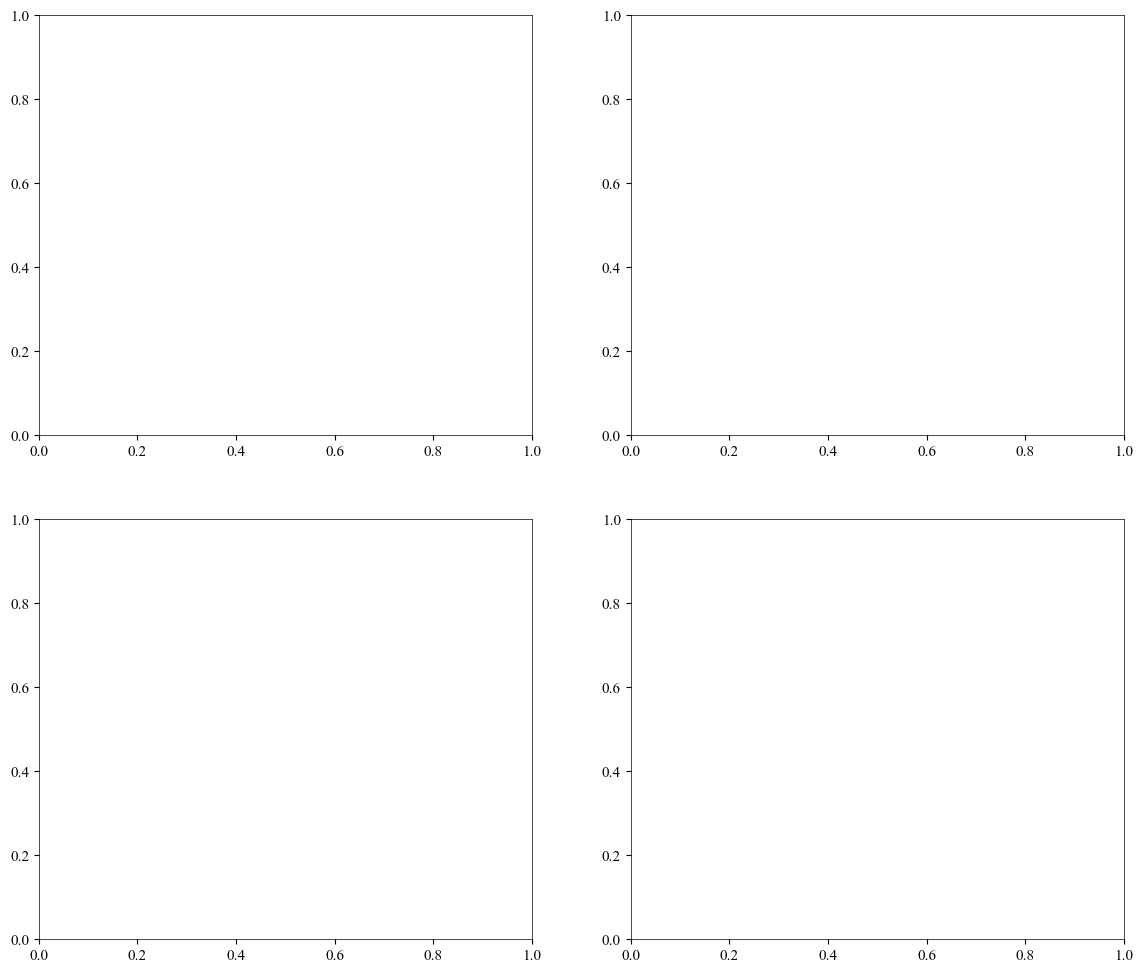

In [ ]:
# === WAVE PROPAGATION VISUALIZATION ===
# For central perturbation: track radial profiles over time

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Radial velocity profiles at different times
times_to_plot = [0, len(ts)//4, len(ts)//2, 3*len(ts)//4]
colors = plt.cm.viridis(np.linspace(0, 1, len(times_to_plot)))

for i, t_idx in enumerate(times_to_plot):
    # Calculate radial distance and radial velocity at this time
    r_t = np.sqrt(sim.positions[t_idx, :, 0]**2 + sim.positions[t_idx, :, 1]**2)
    r_safe_t = np.maximum(r_t, 1e-10)
    
    # Radial velocity = v · r_hat
    v_r = (sim.velocities[t_idx, :, 0] * sim.positions[t_idx, :, 0] + 
           sim.velocities[t_idx, :, 1] * sim.positions[t_idx, :, 1]) / r_safe_t
    
    axes[0, 0].scatter(r_t, v_r, s=5, color=colors[i], alpha=0.5,
                       label=f't = {t_idx*dt:.2f}')
    
    # Expected wave position (ring expanding at sound speed)
    expected_r = cs * t_idx * dt
    if expected_r > 0:
        axes[0, 0].axvline(expected_r, color=colors[i], linestyle='--', alpha=0.5)

axes[0, 0].set_xlabel('Radial distance r')
axes[0, 0].set_ylabel('Radial velocity v_r')
axes[0, 0].set_title('Radial velocity profile (dashed = expected wave front at cs)')
axes[0, 0].legend()
axes[0, 0].axhline(0, color='gray', linestyle='-', alpha=0.3)

# Density-like visualization (particle number density)
# Plot particle positions at different times
for i, t_idx in enumerate(times_to_plot):
    axes[0, 1].scatter(sim.positions[t_idx, :, 0], sim.positions[t_idx, :, 1], 
                       s=3, alpha=0.3, label=f't = {t_idx*dt:.2f}')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
axes[0, 1].set_title('Particle positions at different times')
axes[0, 1].legend()
axes[0, 1].set_aspect('equal')

# Momentum conservation check
momentum_x = np.array([np.sum(masses * sim.velocities[i, :, 0]) for i in range(len(ts))])
momentum_y = np.array([np.sum(masses * sim.velocities[i, :, 1]) for i in range(len(ts))])
t_grid = np.arange(len(ts)) * dt

axes[1, 0].plot(t_grid, momentum_x, label='p_x')
axes[1, 0].plot(t_grid, momentum_y, label='p_y')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Total Momentum')
axes[1, 0].set_title('Momentum Conservation (should be ~0 for symmetric pulse)')
axes[1, 0].legend()

# Angular momentum (should be conserved for radial pulse)
L_z = np.array([np.sum(masses * (sim.positions[i, :, 0] * sim.velocities[i, :, 1] - 
                                  sim.positions[i, :, 1] * sim.velocities[i, :, 0])) 
                for i in range(len(ts))])

axes[1, 1].plot(t_grid, L_z)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Angular Momentum L_z')
axes[1, 1].set_title('Angular Momentum Conservation')
axes[1, 1].axhline(0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()